# Assignment 2 - Image Inpainting

Name: <Zahra Bazghandi>
Matriculation number:

In [1]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from scipy import sparse
from scipy.signal import convolve2d
import numpy as np
from hessian_matrix import *

## Test Image

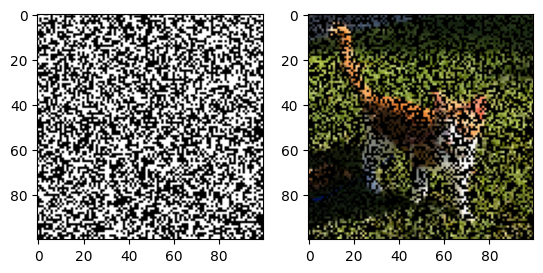

In [4]:
masked_img = np.array(Image.open('masked_cat.png')) / 255
omega = np.array(Image.open('mask.png'))/ 255
g = masked_img.copy()

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(omega, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(g)

## hessian_matrix() function

We provide the implementation of the hessian matrix.

input variables: 
- u: your image
- omega: binary mask
- reg: regularization parameter

Example usage:

In [5]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, omega, reg_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4. -2.  0. -2.  0.  0.  0.  0.  0.]
 [-2.  8. -2.  0. -2.  0.  0.  0.  0.]
 [ 0. -2.  6.  0.  0. -2.  0.  0.  0.]
 [-2.  0.  0.  8. -2.  0. -2.  0.  0.]
 [ 0. -2.  0. -2. 10. -2.  0. -2.  0.]
 [ 0.  0. -2.  0. -2.  8.  0.  0. -2.]
 [ 0.  0.  0. -2.  0.  0.  6. -2.  0.]
 [ 0.  0.  0.  0. -2.  0. -2.  6. -2.]
 [ 0.  0.  0.  0.  0. -2.  0. -2.  6.]]


## Implementation


In [6]:
def GD(g, omega, lmbda):
    """
    Gradient Descent algorithm
    g: masked image of size (M, N, 3)
    omega: binary mask of size (M, N)
    lmbda: regularization parameter
    """
    u_1=g# TODO: replace with actual implementation
    channels=[]
    for i in range(3):
        u=u_1[:,:,i]
        channels.append(u)
        g=u
        for j in range(1000):
            #gradient for i and j in [2,N-1]
            dE=((2*omega[1:-1,1:-1]+6)*u[1:-1,1:-1])-2*(u[2:,1:-1]+u[1:-1,2:]+u[:-2,1:-1]+u[1:-1,:-2]+omega[1:-1,1:-1]*g[1:-1,1:-1])
            
            #on boundaries:
            dE_00=(lmbda*4+2*omega[0,0])*u[0,0]-2*(lmbda*u[1,0]-lmbda*u[0,1]+omega[0,0]*g[0,0])
            dE_NN=(lmbda*4+2*omega[-1,-1])*u[-1,-1]-2*(lmbda*u[-2,-1]+lmbda*u[-1,-2]+omega[-1,-1]*g[-1,-1])
            dE_0j=(lmbda*6+2*omega[0,1:-1])*u[0,1:-1]-2*(lmbda*u[1,1:-1]+lmbda*u[0,2:]+lmbda*u[0,:-2]+omega[0,1:-1]*g[0,1:-1])
            
            dE_Nj=(lmbda*6+2*omega[-1,1:-1])*u[-1,1:-1]-2*(lmbda*u[-1,2:]+lmbda*u[-2,1:-1]+lmbda*u[-1,:-2]+omega[-1,1:-1]*g[-1,1:-1])
           
            dE_i0=(lmbda*6+2*omega[1:-1,0])*u[1:-1,0]-2*(lmbda*u[2:,0]+lmbda*u[1:-1,1]+lmbda*u[:-2,0]+omega[1:-1,0]*g[1:-1,0])
            
            dE_iN=(lmbda*6+2*omega[1:-1,-1])*u[1:-1,-1]-2*(lmbda*u[2:,-1]+lmbda*u[:-2,-1]+lmbda*u[1:-1,-2]+2*omega[1:-1,-1]*g[1:-1,-1])
            
            dE_0N=(lmbda*4+2*omega[0,-1])*u[0,-1]-2*(lmbda*u[1,-1]+lmbda*u[0,-2]+omega[0,-1]*g[0,-1])
            
            dE_N0=(lmbda*4+2*omega[-1,-0])*u[-1,0]-2*(lmbda*u[-1,1]+lmbda*u[-2,0]+omega[-1,0]*g[-1,0])
            
            du = np.zeros((100, 100))
            du[0,0]=dE_00
            du[-1,-1]=dE_NN
            du[0,-1]=dE_0N
            du[-1,0]=dE_N0
            du[0, 1:-1]=dE_0j
            du[-1, 1:-1]=dE_Nj
            du[1:-1,0]=dE_i0
            du[1:-1,-1]=dE_iN
            du[1:-1,1:-1]=dE
            
          
            missing_pixels=(omega==0) 
            epsilon = 0.0004
    
            u[missing_pixels] = u[missing_pixels] - epsilon * du[missing_pixels]
            
           # u[~missing_pixels]=g[~missing_pixels]
            #u = g * ~missing_pixels + u * missing_pixels
    u=np.stack(channels,axis=-1)
    

            
    return u

In [5]:
def LGS(g, omega, lmbda):
    """
    Gradient Descent algorithm
    g: masked image of size (M, N, 3)
    omega: binary mask of size (M, N)
    lmbda: regularization parameter
    """
    u = g  # TODO: replace with actual implementation
    lmbda=1e-2
    err = 10**-6;
    m,n,_=g.shape
    N=m*n
    u_1=g# TODO: replace with actual implementation
    channels=[]
    for i in range(3):
        u=u_1[:,:,i]
        channels.append(u)
        g=u
        for iteration in range(10): 
            u=u.reshape(n,m)
            omega=omega.reshape(n,m)
            g=u
            A=hessian_matrix(u,omega,1e-2)
            L=sparse.tril(A, k=-1, format='csr')
            L=L.toarray()
            D = A.diagonal()
            #D = diags(diagonal,format='csr')
            #D=D.toarray()
            U=sparse.triu(A, k=1, format='csr')
            U=U.toarray()
            #gradient
            dE=((2*omega[1:-1,1:-1]+6)*u[1:-1,1:-1])-2*(u[2:,1:-1]+u[1:-1,2:]+u[:-2,1:-1]+u[1:-1,:-2]+omega[1:-1,1:-1]*g[1:-1,1:-1])
            
            #on boundaries:
            dE_00=(lmbda*4+2*omega[0,0])*u[0,0]-2*(lmbda*u[1,0]-lmbda*u[0,1]+omega[0,0]*g[0,0])
            dE_NN=(lmbda*4+2*omega[-1,-1])*u[-1,-1]-2*(lmbda*u[-2,-1]+lmbda*u[-1,-2]+omega[-1,-1]*g[-1,-1])
            dE_0j=(lmbda*6+2*omega[0,1:-1])*u[0,1:-1]-2*(lmbda*u[1,1:-1]+lmbda*u[0,2:]+lmbda*u[0,:-2]+omega[0,1:-1]*g[0,1:-1])
            
            dE_Nj=(lmbda*6+2*omega[-1,1:-1])*u[-1,1:-1]-2*(lmbda*u[-1,2:]+lmbda*u[-2,1:-1]+lmbda*u[-1,:-2]+omega[-1,1:-1]*g[-1,1:-1])
           
            dE_i0=(lmbda*6+2*omega[1:-1,0])*u[1:-1,0]-2*(lmbda*u[2:,0]+lmbda*u[1:-1,1]+lmbda*u[:-2,0]+omega[1:-1,0]*g[1:-1,0])
            
            dE_iN=(lmbda*6+2*omega[1:-1,-1])*u[1:-1,-1]-2*(lmbda*u[2:,-1]+lmbda*u[:-2,-1]+lmbda*u[1:-1,-2]+2*omega[1:-1,-1]*g[1:-1,-1])
            
            dE_0N=(lmbda*4+2*omega[0,-1])*u[0,-1]-2*(lmbda*u[1,-1]+lmbda*u[0,-2]+omega[0,-1]*g[0,-1])
            
            dE_N0=(lmbda*4+2*omega[-1,-0])*u[-1,0]-2*(lmbda*u[-1,1]+lmbda*u[-2,0]+omega[-1,0]*g[-1,0])
            
            du = np.zeros((100, 100))
            du[0,0]=dE_00
            du[-1,-1]=dE_NN
            du[0,-1]=dE_0N
            du[-1,0]=dE_N0
            du[0, 1:-1]=dE_0j
            du[-1, 1:-1]=dE_Nj
            du[1:-1,0]=dE_i0
            du[1:-1,-1]=dE_iN
            du[1:-1,1:-1]=dE
            
            dEE=du
            u= u.reshape(-1)
            dEE = dEE.reshape(-1)
            b=A@u-dEE
            #omega=omega.reshape(-1)
            #missing_pixels=(omega==0)
            
            #dunew=dunew.reshape(-1)
            u=u.reshape(-1,1)
            b=b.reshape(-1,1)
            D=D.reshape(-1,1)
            du = np.zeros((N,1));
            dunew= np.zeros((N,1))
            for ii in range(20):
            
          
                dunew= (b -(U+L) @ du)/D
                du = dunew
                du=du.reshape(n,m)
                Ldu=sparse.tril(du, k=-1, format='csr')
                Ldu=Ldu.toarray()
                Udu=sparse.triu(du, k=1, format='csr')
                Udu=Udu.toarray()
    
                du=Ldu+Udu
    
                du=du.reshape(-1,1)
               
                
        
            u = u+du
            if np.mean(np.abs(du))<err:
                break
        itG = iteration;
    u=u.reshape(n,m)                
    u=np.stack(channels,axis=-1)
        
    return u

## GRADIENT DESCENT

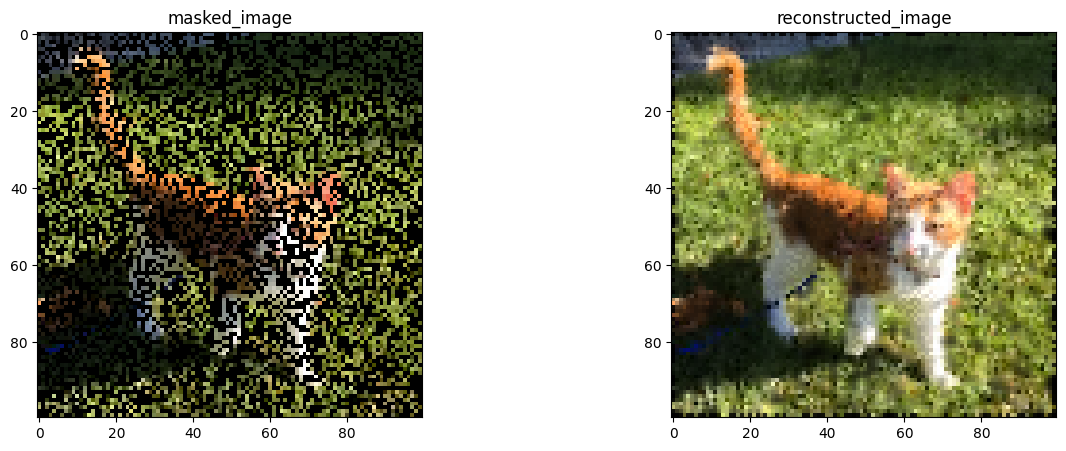

In [7]:
# run gradient descent algorithm
inpainted_img_gd = GD(g, omega,lmbda=1e-1)

# for visualization purpose 
inpainted_img_gd = np.clip(inpainted_img_gd, 0, 1)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(1, 2, 2)
plt.imshow(inpainted_img_gd)


ax1.set_title("masked_image")
ax2.set_title("reconstructed_image")
plt.show()

## GAUSS - SEIDEL

In [8]:
# run gradient descent algorithm
inpainted_img_lgs = LGS(g, omega,1e-2)

# for visualization purpose 
inpainted_img_lgs = np.clip(inpainted_img_lgs, 0, 1)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(1, 2, 2)
plt.imshow(inpainted_img_lgs)


ax1.set_title("masked_image")
ax2.set_title("reconstructed_image")
plt.show()

NameError: name 'LGS' is not defined

### Effect of the regularization parameter lmbda 

In gradient descent it controls the changes in pixe value, if it is set to be high values, then the gradient can become very large and consequwntly creating large values for some pixels which is not desirable as when one displays them in a plot may see black regions. on the other hand, If it is too small, then some pixwls are not updated. I my case lmbda=5 inpaint the picture and as it goes to values less than zero the boundaries start to turn black. In LGS this is also the case because we use the gradient of our pixels and it controls the value of b which is then used to update the pixels, therefore we do not want it to be either too large or small.